In [1]:
import os
import scipy
import re

from mido import MidiFile
import networkx as nx
from networkx_viewer import Viewer
import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

print(scipy.__version__)
print(matplotlib.__version__)
print(nx.__version__)

1.7.3
3.6.2
2.8.4


In [ ]:
mid = MidiFile("C:\\Users\\vamvp\Desktop\\Albert King - Born Under A Bad Sign.mid", clip=True)

In [ ]:
for msg in mid.tracks[1]:
    print(msg)

In [ ]:
G = nx.read_edgelist("./slac/embeddings/edgelist0/program_test.edgelist")
print("Network Loaded")


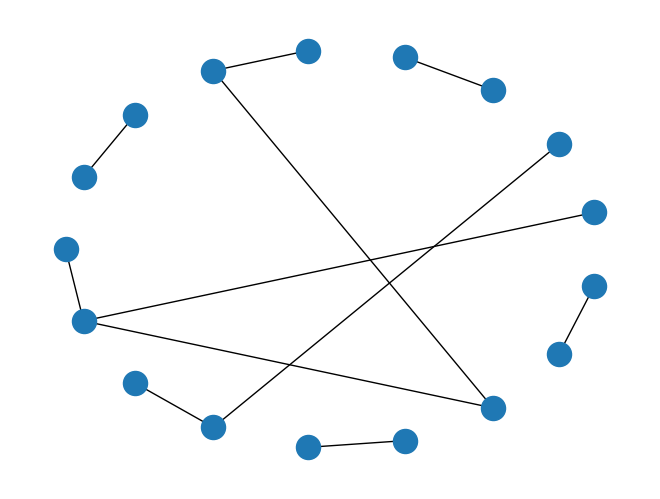

In [26]:
nx.draw_shell(G)

In [2]:
def complete_graph(input_path) -> nx.Graph:
    edgelists = [qf for qf in os.listdir(input_path)
                 if qf.endswith('.edgelist') and not qf.startswith('_')]
    g = None

    print('loading edgelists...')
    for eg in edgelists:
        print('- ' + eg)
        h = nx.read_edgelist(os.path.join(input_path, eg), nodetype=str, create_using=nx.DiGraph(), delimiter=' ')
        for edge in h.edges():
            h[edge[0]][edge[1]]['weight'] = 1

        g = h if g is None else nx.compose(g, h)

    g = g.to_undirected()

    print('Nodes: %d' % nx.number_of_nodes(g))
    print('Edges: %d' % nx.number_of_edges(g))
    return g


In [3]:
com_gr = complete_graph("./slac/embeddings/Test Edgelists")

loading edgelists...
- full_edgelist.edgelist
- notes.edgelist
- program.edgelist
- tempo.edgelist
- time.signature.edgelist
Nodes: 2703
Edges: 19366


In [ ]:
nx.draw(com_gr, )

In [10]:
nx.write_edgelist(com_gr, "C:\\Users\\vamvp\Desktop\Test Edgelists\\full_edgelist.edgelist")

In [4]:
app = Viewer(com_gr)
app.mainloop()